In [22]:
!pip install Bio

In [23]:
# Imports
import pandas as pd
from Bio.PDB import PDBList, PDBParser
from Bio.PDB.Polypeptide import is_aa
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from scipy.stats import pearsonr  # Import for Pearson correlation
import numpy as np

pdbl = PDBList()

# Amino acid 3-letter to 1-letter code dictionary
aa_3to1 = {
    "ALA": "A", "ARG": "R", "ASN": "N", "ASP": "D", "CYS": "C",
    "GLU": "E", "GLN": "Q", "GLY": "G", "HIS": "H", "ILE": "I",
    "LEU": "L", "LYS": "K", "MET": "M", "PHE": "F", "PRO": "P",
    "SER": "S", "THR": "T", "TRP": "W", "TYR": "Y", "VAL": "V"
}

# List of PDB IDs
pdb_ids = ['2BXO', '1A3N', '1GFL', '2LYZ', '1RCX', '1QQW', '1EFC', '1DP0', '1A8E', '2GLS', '1AKE', '1QQ2', '1PPI']

In [24]:
# Modified data fetching and processing
def get_pdb_sequence_and_b_factors(pdb_id):
    try:
        pdb_file = pdbl.retrieve_pdb_file(pdb_id, file_format="pdb")
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure(pdb_id, pdb_file)

        sequences = []
        b_factors = []

        for model in structure:
            for chain in model:
                chain_sequence = ""
                avg_b_factors = []
                backbone_b_factors = []
                sidechain_b_factors = []
                ca_b_factors = []
                last_residue_id = None

                for residue in chain.get_residues():
                    if is_aa(residue, standard=True):
                        if last_residue_id is not None:
                            gap = residue.get_id()[1] - last_residue_id
                            if gap > 1:
                                print(f"Gap detected in chain {chain.get_id()} of {pdb_id}. Skipping chain.")
                                return [], []

                        resname = residue.resname.strip()
                        chain_sequence += aa_3to1[resname]

                        # Calculate B-factor metrics
                        all_b_factors = [atom.get_bfactor() for atom in residue]
                        avg_b_factors.append(sum(all_b_factors) / len(all_b_factors))

                        backbone_atoms = ["N", "CA", "C", "O"]
                        backbone_b = [atom.get_bfactor() for atom in residue if atom.get_name() in backbone_atoms]
                        sidechain_b = [atom.get_bfactor() for atom in residue if atom.get_name() not in backbone_atoms]
                        ca_b = [atom.get_bfactor() for atom in residue if atom.get_name() == "CA"]

                        if backbone_b:
                            backbone_b_factors.append(sum(backbone_b) / len(backbone_b))
                        else:
                            backbone_b_factors.append(None)

                        if sidechain_b:
                            sidechain_b_factors.append(sum(sidechain_b) / len(sidechain_b))
                        else:
                            sidechain_b_factors.append(None)

                        if ca_b:
                            ca_b_factors.append(ca_b[0])
                        else:
                            ca_b_factors.append(None)

                        last_residue_id = residue.get_id()[1]

                if len(chain_sequence) == len(avg_b_factors):
                    sequences.append(chain_sequence)
                    b_factors.append({
                        "avg_b_factor": avg_b_factors,
                        "backbone_b_factor": backbone_b_factors,
                        "sidechain_b_factor": sidechain_b_factors,
                        "ca_b_factor": ca_b_factors
                    })

        return sequences, b_factors
    except Exception as e:
        print(f"Error fetching PDB {pdb_id}: {e}")
        return [], []

# Step 1: Collect data for all proteins
data = []
for pdb_id in pdb_ids:
    print(f"Fetching data for PDB ID: {pdb_id}")
    sequences, b_factors = get_pdb_sequence_and_b_factors(pdb_id)

    if sequences and b_factors:
        for seq, b_factor_dict in zip(sequences, b_factors):
            # Add normalized position information specific to this protein
            seq_length = len(seq)

            data.append({
                "pdb_id": pdb_id,
                "sequence": seq,
                "seq_length": seq_length,
                "avg_b_factor": b_factor_dict["avg_b_factor"],
                "backbone_b_factor": b_factor_dict["backbone_b_factor"],
                "sidechain_b_factor": b_factor_dict["sidechain_b_factor"],
                "ca_b_factor": b_factor_dict["ca_b_factor"]
            })

# Step 2: Convert to DataFrame and remove duplicates
df = pd.DataFrame(data)
df_clean = df.drop_duplicates(subset=['pdb_id']).reset_index(drop=True)

# Display the cleaned DataFrame to verify
print("Cleaned DataFrame:")
print(df_clean[['pdb_id', 'sequence', 'seq_length']])
print(f"\nTotal unique PDB IDs: {df_clean['pdb_id'].nunique()}")

# Step 3: Use `df_clean` in the remaining code, including `prepare_combined_dataset`


Fetching data for PDB ID: 2BXO
Structure exists: '/content/bx/pdb2bxo.ent' 
Fetching data for PDB ID: 1A3N
Structure exists: '/content/a3/pdb1a3n.ent' 
Fetching data for PDB ID: 1GFL
Structure exists: '/content/gf/pdb1gfl.ent' 
Fetching data for PDB ID: 2LYZ
Structure exists: '/content/ly/pdb2lyz.ent' 
Fetching data for PDB ID: 1RCX
Structure exists: '/content/rc/pdb1rcx.ent' 
Fetching data for PDB ID: 1QQW
Structure exists: '/content/qq/pdb1qqw.ent' 
Fetching data for PDB ID: 1EFC
Structure exists: '/content/ef/pdb1efc.ent' 
Fetching data for PDB ID: 1DP0
Structure exists: '/content/dp/pdb1dp0.ent' 
Fetching data for PDB ID: 1A8E
Structure exists: '/content/a8/pdb1a8e.ent' 
Fetching data for PDB ID: 2GLS
Structure exists: '/content/gl/pdb2gls.ent' 
Fetching data for PDB ID: 1AKE
Structure exists: '/content/ak/pdb1ake.ent' 
Fetching data for PDB ID: 1QQ2
Structure exists: '/content/qq/pdb1qq2.ent' 
Fetching data for PDB ID: 1PPI
Structure exists: '/content/pp/pdb1ppi.ent' 
Cleaned Data

In [25]:
# Step 1: Collect data for all proteins
data = []
for pdb_id in pdb_ids:
    print(f"Fetching data for PDB ID: {pdb_id}")
    sequences, b_factors = get_pdb_sequence_and_b_factors(pdb_id)

    if sequences and b_factors:
        for seq, b_factor_dict in zip(sequences, b_factors):
            seq_length = len(seq)

            data.append({
                "pdb_id": pdb_id,
                "sequence": seq,
                "seq_length": seq_length,
                "avg_b_factor": b_factor_dict["avg_b_factor"],
                "backbone_b_factor": b_factor_dict["backbone_b_factor"],
                "sidechain_b_factor": b_factor_dict["sidechain_b_factor"],
                "ca_b_factor": b_factor_dict["ca_b_factor"]
            })

# Step 2: Convert to DataFrame and remove duplicates, renaming as `df`
df = pd.DataFrame(data).drop_duplicates(subset=['pdb_id']).reset_index(drop=True)

# Display the cleaned DataFrame to verify
print("Cleaned DataFrame (renamed as `df`):")
print(df[['pdb_id', 'sequence', 'seq_length']])
print(f"\nTotal unique PDB IDs: {df['pdb_id'].nunique()}")

Fetching data for PDB ID: 2BXO
Structure exists: '/content/bx/pdb2bxo.ent' 
Fetching data for PDB ID: 1A3N
Structure exists: '/content/a3/pdb1a3n.ent' 
Fetching data for PDB ID: 1GFL
Structure exists: '/content/gf/pdb1gfl.ent' 
Fetching data for PDB ID: 2LYZ
Structure exists: '/content/ly/pdb2lyz.ent' 
Fetching data for PDB ID: 1RCX
Structure exists: '/content/rc/pdb1rcx.ent' 
Fetching data for PDB ID: 1QQW
Structure exists: '/content/qq/pdb1qqw.ent' 
Fetching data for PDB ID: 1EFC
Structure exists: '/content/ef/pdb1efc.ent' 
Fetching data for PDB ID: 1DP0
Structure exists: '/content/dp/pdb1dp0.ent' 
Fetching data for PDB ID: 1A8E
Structure exists: '/content/a8/pdb1a8e.ent' 
Fetching data for PDB ID: 2GLS
Structure exists: '/content/gl/pdb2gls.ent' 
Fetching data for PDB ID: 1AKE
Structure exists: '/content/ak/pdb1ake.ent' 
Fetching data for PDB ID: 1QQ2
Structure exists: '/content/qq/pdb1qq2.ent' 
Fetching data for PDB ID: 1PPI
Structure exists: '/content/pp/pdb1ppi.ent' 
Cleaned Data

In [26]:
# Remove duplicate PDB IDs, keeping the first occurrence of each unique pdb_id
df_clean = df.drop_duplicates(subset=['pdb_id']).reset_index(drop=True)

# Display the cleaned DataFrame to verify
print("Cleaned DataFrame:")
print(df_clean[['pdb_id', 'sequence', 'seq_length']])
print(f"\nTotal unique PDB IDs: {df_clean['pdb_id'].nunique()}")

Cleaned DataFrame:
   pdb_id                                           sequence  seq_length
0    2BXO  HKSEVAHRFKDLGEENFKALVLIAFAQYLQQCPFEDHVKLVNEVTE...         582
1    1A3N  VLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHF...         141
2    1GFL  ASKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...         230
3    2LYZ  KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRN...         129
4    1RCX  ASVGFKAGVKDYKLTYYTPEYETLDTDILAAFRVSPQPGVPPEEAG...         467
5    1QQW  SRDPASDQMQHWKEQRAAQKADVLTTGAGNPVGDKLNVITVGPRGP...         499
6    1EFC  TKPHVNVGTIGHVDHGKTTLTAAITTVLAKTYGGAARAFDQIDNAP...         386
7    1DP0  RRDWENPGVTQLNRLAAHPPFASWRNSEEARTDRPSQQLRSLNGEW...        1011
8    1A8E  DKTVRWCAVSEHEATKCQSFRDHMKSVIPSDGPSVACVKKASYLDC...         329
9    2GLS  SAEHVLTMLNEHEVKFVDLRFTDTKGKEQHVTIPAHQVNAEFFEEG...         468
10   1AKE  MRIILLGAPGAGKGTQAQFIMEKYGIPQISTGDMLRAAVKSGSELG...         214
11   1QQ2  SGNAKIGHPAPSFKATAVMPDGQFKDISLSDYKGKYVVFFFYPLDF...         173
12   1PPI  QYAPQTQSGRTSIVHLFEWRW

In [27]:
# Define all possible amino acids
ALL_AMINO_ACIDS = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
                   'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# Create a global encoder that knows about all amino acids
global_encoder = OneHotEncoder(sparse_output=False)
# Fitting the encoder with a DataFrame to avoid warnings about feature names
global_encoder.fit(pd.DataFrame(ALL_AMINO_ACIDS, columns=['amino_acid']))

def prepare_features_with_position(sequence, seq_length):
    # One-hot encode amino acids using global encoder
    amino_acids = list(sequence)
    amino_acids_df = pd.DataFrame(amino_acids, columns=['amino_acid'])
    X_one_hot = global_encoder.transform(amino_acids_df)

    # Normalize one-hot encoded features
    X_one_hot = X_one_hot / np.sqrt(X_one_hot.shape[1])

    # Add positional information (normalized position within THIS protein)
    positions = np.arange(len(sequence)) / seq_length

    # Combine features
    X = np.hstack((X_one_hot, positions.reshape(-1, 1)))

    return X

def prepare_combined_dataset(df, b_factor_type):
    all_features = []
    all_targets = []

    print(f"\nPreparing dataset for {b_factor_type}")
    print(f"Number of proteins: {len(df)}")

    for idx, row in df.iterrows():
        sequence = row['sequence']
        b_factors = row[b_factor_type]

        # Skip if sequence or B-factors are empty or mismatched in length
        if not sequence or not b_factors or len(sequence) != len(b_factors):
            print(f"Skipping {row['pdb_id']} due to empty or mismatched data")
            continue

        print(f"\nProcessing {row['pdb_id']}:")
        print(f"Sequence length: {len(sequence)}")

        # Get features and targets
        X = prepare_features_with_position(sequence, row['seq_length'])
        y = np.array(b_factors)

        print(f"Feature shape: {X.shape}")
        print(f"Target shape: {y.shape}")

        all_features.append(X)
        all_targets.extend(y)

    # Ensure there’s data to combine
    if all_features and all_targets:
        X_combined = np.vstack(all_features)
        y_combined = np.array(all_targets)
    else:
        raise ValueError("No valid data found after processing all rows")

    print("\nFinal combined shapes:")
    print(f"X shape: {X_combined.shape}")
    print(f"y shape: {y_combined.shape}")

    return X_combined, y_combined


# Test the data preparation with cleaned dataset
X, y = prepare_combined_dataset(df_clean, 'avg_b_factor')



Preparing dataset for avg_b_factor
Number of proteins: 13

Processing 2BXO:
Sequence length: 582
Feature shape: (582, 21)
Target shape: (582,)

Processing 1A3N:
Sequence length: 141
Feature shape: (141, 21)
Target shape: (141,)

Processing 1GFL:
Sequence length: 230
Feature shape: (230, 21)
Target shape: (230,)

Processing 2LYZ:
Sequence length: 129
Feature shape: (129, 21)
Target shape: (129,)

Processing 1RCX:
Sequence length: 467
Feature shape: (467, 21)
Target shape: (467,)

Processing 1QQW:
Sequence length: 499
Feature shape: (499, 21)
Target shape: (499,)

Processing 1EFC:
Sequence length: 386
Feature shape: (386, 21)
Target shape: (386,)

Processing 1DP0:
Sequence length: 1011
Feature shape: (1011, 21)
Target shape: (1011,)

Processing 1A8E:
Sequence length: 329
Feature shape: (329, 21)
Target shape: (329,)

Processing 2GLS:
Sequence length: 468
Feature shape: (468, 21)
Target shape: (468,)

Processing 1AKE:
Sequence length: 214
Feature shape: (214, 21)
Target shape: (214,)

Pr


Training models for avg_b_factor

Preparing dataset for avg_b_factor
Number of proteins: 13

Processing 2BXO:
Sequence length: 582
Feature shape: (582, 21)
Target shape: (582,)

Processing 1A3N:
Sequence length: 141
Feature shape: (141, 21)
Target shape: (141,)

Processing 1GFL:
Sequence length: 230
Feature shape: (230, 21)
Target shape: (230,)

Processing 2LYZ:
Sequence length: 129
Feature shape: (129, 21)
Target shape: (129,)

Processing 1RCX:
Sequence length: 467
Feature shape: (467, 21)
Target shape: (467,)

Processing 1QQW:
Sequence length: 499
Feature shape: (499, 21)
Target shape: (499,)

Processing 1EFC:
Sequence length: 386
Feature shape: (386, 21)
Target shape: (386,)

Processing 1DP0:
Sequence length: 1011
Feature shape: (1011, 21)
Target shape: (1011,)

Processing 1A8E:
Sequence length: 329
Feature shape: (329, 21)
Target shape: (329,)

Processing 2GLS:
Sequence length: 468
Feature shape: (468, 21)
Target shape: (468,)

Processing 1AKE:
Sequence length: 214
Feature shape: 

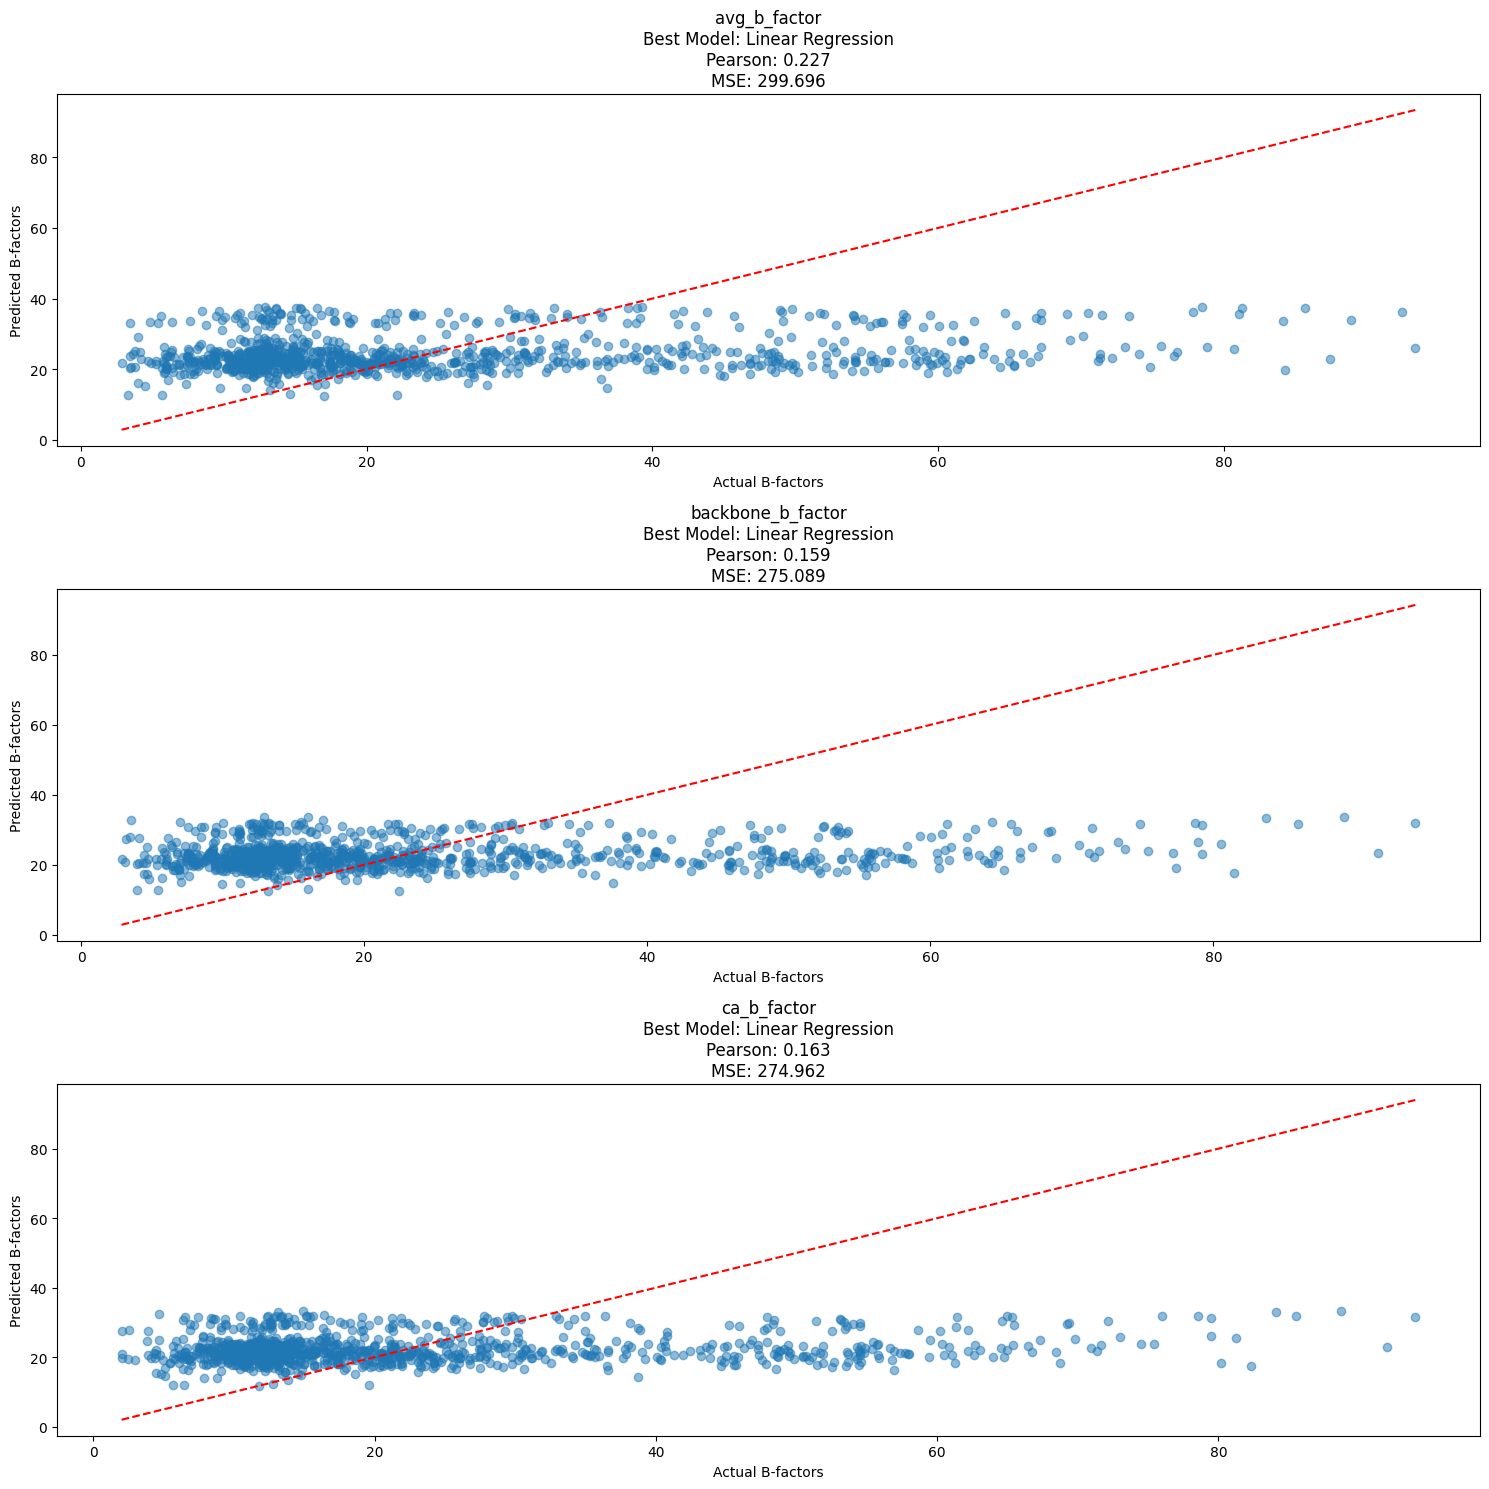


Summary of Best Models:
B-factor Type        Best Model           Pearson    MSE       
------------------------------------------------------------
avg_b_factor         Linear Regression    0.2270    299.6965
backbone_b_factor    Linear Regression    0.1586    275.0893
ca_b_factor          Linear Regression    0.1632    274.9623


In [28]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def train_models_for_b_factor(df_clean, b_factor_type):
    # Prepare combined dataset from all proteins
    X, y = prepare_combined_dataset(df_clean, b_factor_type)

    # Normalize target values
    y_scaler = MinMaxScaler()
    y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize models with smaller alpha values
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=0.01),
        'Lasso Regression': Lasso(alpha=0.001)
    }

    best_result = None
    best_pearson = -float('inf')

    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Transform back to original scale
        y_pred_original = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
        y_test_original = y_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

        # Calculate metrics
        pearson_corr, _ = pearsonr(y_test_original, y_pred_original)
        mse = mean_squared_error(y_test_original, y_pred_original)

        # Store result if it's the best so far
        if pearson_corr > best_pearson:
            best_pearson = pearson_corr
            best_result = {
                'model_name': name,
                'model': model,
                'pearson_corr': pearson_corr,
                'mse': mse,
                'predictions': y_pred_original,
                'targets': y_test_original
            }

        print(f"{name} - {b_factor_type}:")
        print(f"Pearson Correlation: {pearson_corr:.4f}")
        print(f"MSE: {mse:.4f}\n")

    return best_result

# Train models for each B-factor type
b_factor_types = ["avg_b_factor", "backbone_b_factor", "ca_b_factor"]
best_results = {}

# Set up the plot
plt.figure(figsize=(15, 15))

for i, b_type in enumerate(b_factor_types):
    print(f"\nTraining models for {b_type}")
    best_result = train_models_for_b_factor(df_clean, b_type)
    best_results[b_type] = best_result

    # Plot the best model results
    plt.subplot(3, 1, i + 1)
    plt.scatter(best_result['targets'], best_result['predictions'], alpha=0.5)
    plt.plot([min(best_result['targets']), max(best_result['targets'])],
             [min(best_result['targets']), max(best_result['targets'])], 'r--')

    plt.title(f'{b_type}\nBest Model: {best_result["model_name"]}\n' +
              f'Pearson: {best_result["pearson_corr"]:.3f}\nMSE: {best_result["mse"]:.3f}')
    plt.xlabel('Actual B-factors')
    plt.ylabel('Predicted B-factors')

plt.tight_layout()
plt.show()

# Print summary table of best models
print("\nSummary of Best Models:")
print("="*60)
print(f"{'B-factor Type':<20} {'Best Model':<20} {'Pearson':<10} {'MSE':<10}")
print("-"*60)

for b_type, result in best_results.items():
    print(f"{b_type:<20} {result['model_name']:<20} {result['pearson_corr']:.4f}    {result['mse']:.4f}")


Training models for avg_b_factor

Preparing dataset for avg_b_factor
Number of proteins: 13

Processing 2BXO:
Sequence length: 582
Feature shape: (582, 21)
Target shape: (582,)

Processing 1A3N:
Sequence length: 141
Feature shape: (141, 21)
Target shape: (141,)

Processing 1GFL:
Sequence length: 230
Feature shape: (230, 21)
Target shape: (230,)

Processing 2LYZ:
Sequence length: 129
Feature shape: (129, 21)
Target shape: (129,)

Processing 1RCX:
Sequence length: 467
Feature shape: (467, 21)
Target shape: (467,)

Processing 1QQW:
Sequence length: 499
Feature shape: (499, 21)
Target shape: (499,)

Processing 1EFC:
Sequence length: 386
Feature shape: (386, 21)
Target shape: (386,)

Processing 1DP0:
Sequence length: 1011
Feature shape: (1011, 21)
Target shape: (1011,)

Processing 1A8E:
Sequence length: 329
Feature shape: (329, 21)
Target shape: (329,)

Processing 2GLS:
Sequence length: 468
Feature shape: (468, 21)
Target shape: (468,)

Processing 1AKE:
Sequence length: 214
Feature shape: 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.2276

Training model: Layers: [128, 64], Batch: 32, LR: 0.005
Pearson Correlation: 0.2260

Training model: Layers: [128, 64], Batch: 64, LR: 0.001
Pearson Correlation: 0.2326

Training model: Layers: [128, 64], Batch: 64, LR: 0.005
Pearson Correlation: 0.2277

Training model: Layers: [256, 128, 64, 1], Batch: 32, LR: 0.001


<ipython-input-29-47efaf5bdef9>:72: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(y_test, y_pred.flatten())


Pearson Correlation: nan

Training model: Layers: [256, 128, 64, 1], Batch: 32, LR: 0.005
Pearson Correlation: nan

Training model: Layers: [256, 128, 64, 1], Batch: 64, LR: 0.001
Pearson Correlation: nan

Training model: Layers: [256, 128, 64, 1], Batch: 64, LR: 0.005
Pearson Correlation: 0.2288

Model Performance Summary for avg_b_factor (sorted by correlation):
--------------------------------------------------------------------------------
1. Layers: [128, 64], Batch: 64, LR: 0.001
   Correlation: 0.2326
   P-value: 4.6532e-14
--------------------------------------------------------------------------------
2. Layers: [128, 64], Batch: 64, LR: 0.005
   Correlation: 0.2277
   P-value: 1.6201e-13
--------------------------------------------------------------------------------
3. Layers: [128, 64], Batch: 32, LR: 0.001
   Correlation: 0.2276
   P-value: 1.6485e-13
--------------------------------------------------------------------------------
4. Layers: [128, 64], Batch: 32, LR: 0.005

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.1686

Training model: Layers: [128, 64], Batch: 32, LR: 0.005
Pearson Correlation: 0.1754

Training model: Layers: [128, 64], Batch: 64, LR: 0.001
Pearson Correlation: 0.1703

Training model: Layers: [128, 64], Batch: 64, LR: 0.005
Pearson Correlation: 0.1599

Training model: Layers: [256, 128, 64, 1], Batch: 32, LR: 0.001


<ipython-input-29-47efaf5bdef9>:72: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(y_test, y_pred.flatten())


Pearson Correlation: nan

Training model: Layers: [256, 128, 64, 1], Batch: 32, LR: 0.005
Pearson Correlation: nan

Training model: Layers: [256, 128, 64, 1], Batch: 64, LR: 0.001
Pearson Correlation: 0.1676

Training model: Layers: [256, 128, 64, 1], Batch: 64, LR: 0.005
Pearson Correlation: 0.1788

Model Performance Summary for backbone_b_factor (sorted by correlation):
--------------------------------------------------------------------------------
1. Layers: [128, 64], Batch: 32, LR: 0.005
   Correlation: 0.1754
   P-value: 1.5836e-08
--------------------------------------------------------------------------------
2. Layers: [128, 64], Batch: 64, LR: 0.001
   Correlation: 0.1703
   P-value: 4.1276e-08
--------------------------------------------------------------------------------
3. Layers: [128, 64], Batch: 32, LR: 0.001
   Correlation: 0.1686
   P-value: 5.6417e-08
--------------------------------------------------------------------------------
4. Layers: [128, 64], Batch: 64, L

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.1716

Training model: Layers: [128, 64], Batch: 32, LR: 0.005
Pearson Correlation: 0.1702

Training model: Layers: [128, 64], Batch: 64, LR: 0.001
Pearson Correlation: 0.1771

Training model: Layers: [128, 64], Batch: 64, LR: 0.005
Pearson Correlation: 0.1767

Training model: Layers: [256, 128, 64, 1], Batch: 32, LR: 0.001


<ipython-input-29-47efaf5bdef9>:72: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(y_test, y_pred.flatten())


Pearson Correlation: nan

Training model: Layers: [256, 128, 64, 1], Batch: 32, LR: 0.005
Pearson Correlation: nan

Training model: Layers: [256, 128, 64, 1], Batch: 64, LR: 0.001
Pearson Correlation: nan

Training model: Layers: [256, 128, 64, 1], Batch: 64, LR: 0.005
Pearson Correlation: nan

Model Performance Summary for ca_b_factor (sorted by correlation):
--------------------------------------------------------------------------------
1. Layers: [128, 64], Batch: 64, LR: 0.001
   Correlation: 0.1771
   P-value: 1.1377e-08
--------------------------------------------------------------------------------
2. Layers: [128, 64], Batch: 64, LR: 0.005
   Correlation: 0.1767
   P-value: 1.2414e-08
--------------------------------------------------------------------------------
3. Layers: [128, 64], Batch: 32, LR: 0.001
   Correlation: 0.1716
   P-value: 3.2646e-08
--------------------------------------------------------------------------------
4. Layers: [128, 64], Batch: 32, LR: 0.005
   

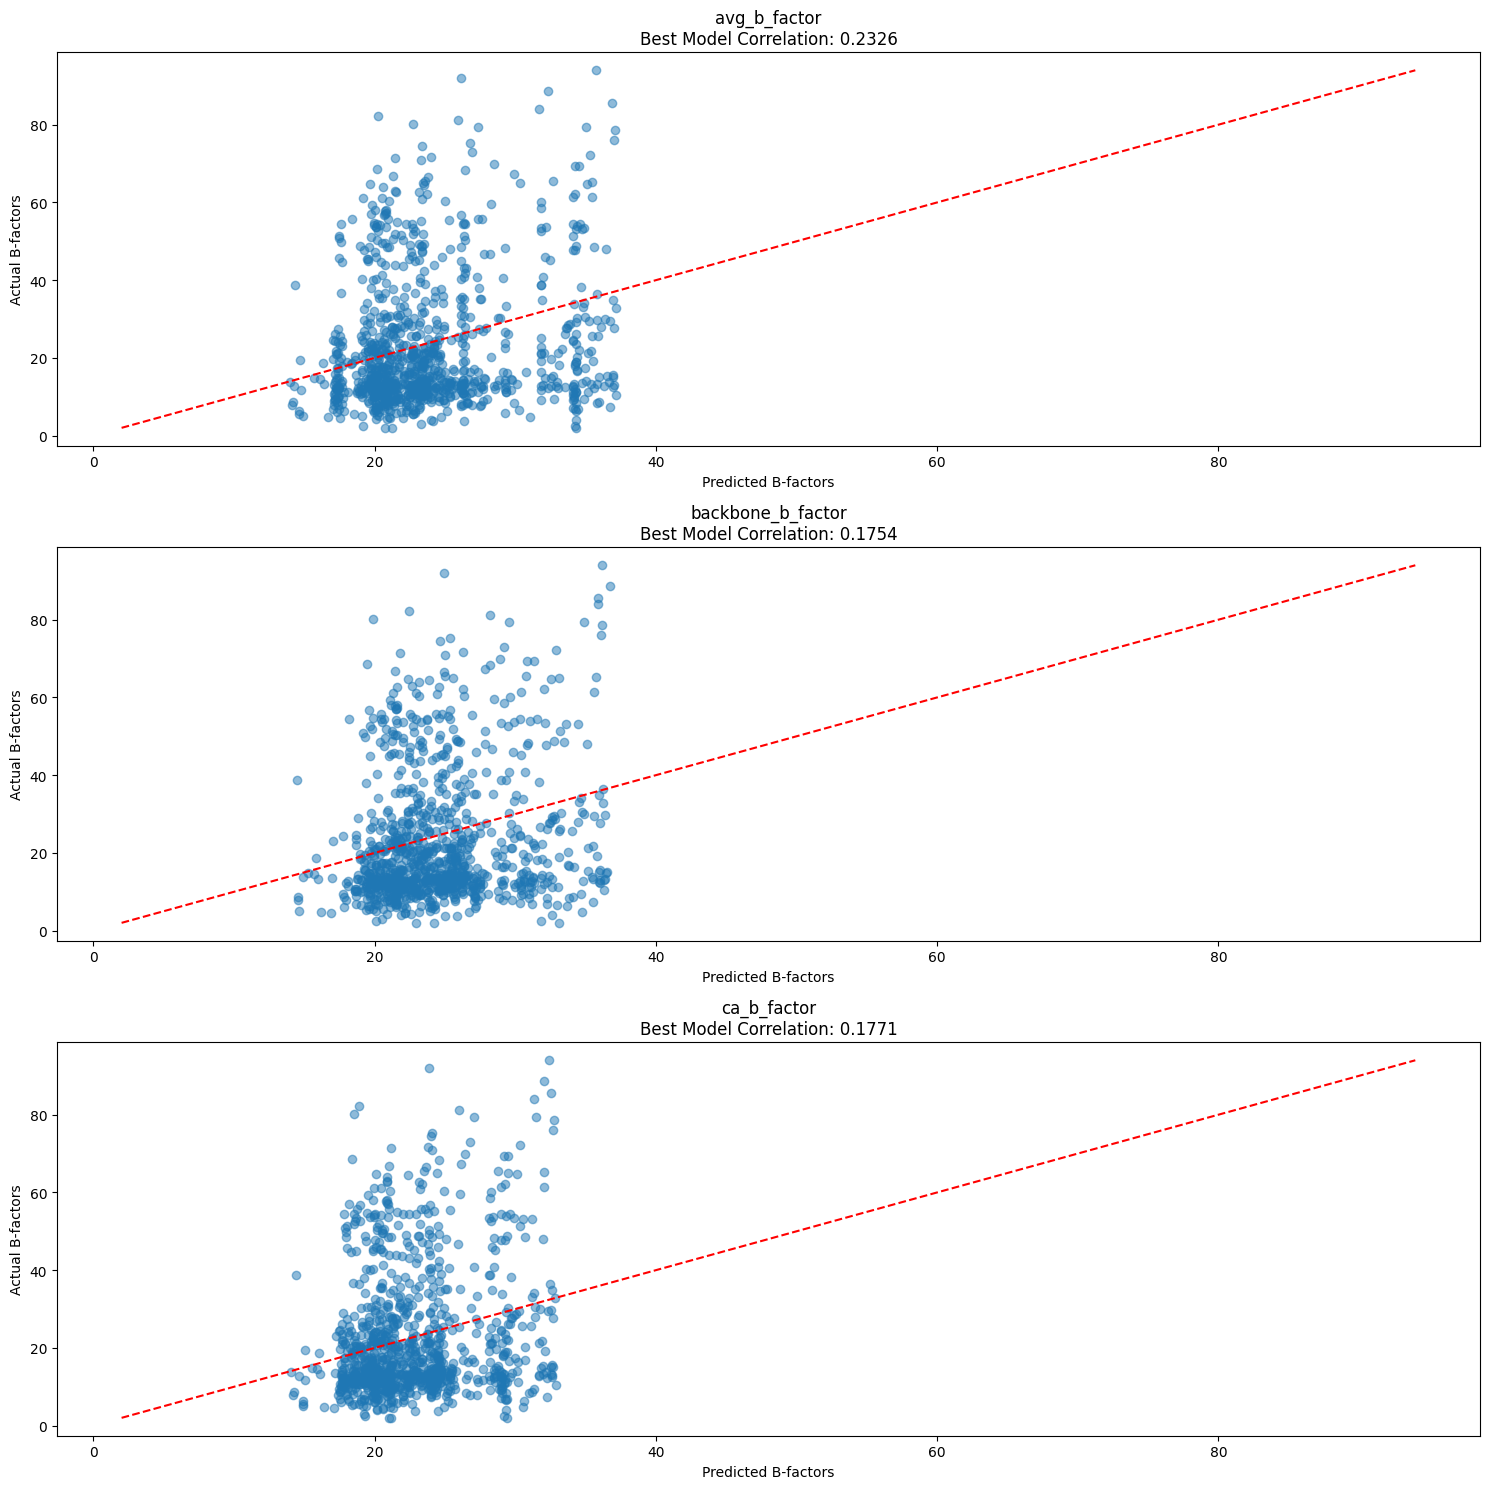


Best Model Configurations:

avg_b_factor:
Layers: [128, 64]
Batch Size: 64
Learning Rate: 0.001
Correlation: 0.2326

backbone_b_factor:
Layers: [128, 64]
Batch Size: 32
Learning Rate: 0.005
Correlation: 0.1754

ca_b_factor:
Layers: [128, 64]
Batch Size: 64
Learning Rate: 0.001
Correlation: 0.1771


In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from itertools import product

# Updated b_factor_types to iterate over multiple types
b_factor_types = ["avg_b_factor", "backbone_b_factor", "ca_b_factor"]
all_type_results = {}

for b_factor_type in b_factor_types:
    print(f"\n{'='*40}")
    print(f"Training models for {b_factor_type}")
    print(f"{'='*40}")

    # Prepare combined dataset with the new function
    X, y = prepare_combined_dataset(df, b_factor_type)

    # Reshape data for RNN: (samples, time steps, features)
    X = X.reshape(X.shape[0], 1, X.shape[1])

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define hyperparameter combinations for RNN
    layer_configurations = [
        [128, 64], # Two-layer configuration
        [256, 128, 64, 1]  # Deeper configuration
    ]
    batch_sizes = [32, 64]
    learning_rates = [0.001, 0.005]

    # Store results
    results = []

    # Try all combinations
    for layers, batch_size, lr in product(layer_configurations, batch_sizes, learning_rates):
        # Create model name
        model_name = f"Layers: {layers}, Batch: {batch_size}, LR: {lr}"
        print(f"\nTraining model: {model_name}")

        # Build model
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])))

        # Add RNN layers according to configuration
        for units in layers:
            model.add(tf.keras.layers.SimpleRNN(units, return_sequences=True, activation='relu'))
        # Final RNN layer without return_sequences
        model.add(tf.keras.layers.SimpleRNN(layers[-1], activation='relu', return_sequences=False))

        # Output layer
        model.add(tf.keras.layers.Dense(1))

        # Compile model
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        # Train model
        history = model.fit(
            X_train, y_train,
            epochs=10,
            batch_size=batch_size,
            validation_split=0.2,
            verbose=0
        )

        # Evaluate
        y_pred = model.predict(X_test, verbose=0)
        correlation, p_value = pearsonr(y_test, y_pred.flatten())

        # Store results
        results.append({
            'model_name': model_name,
            'correlation': correlation,
            'p_value': p_value,
            'history': history.history,
            'predictions': y_pred.flatten(),
            'layers': layers,
            'batch_size': batch_size,
            'learning_rate': lr
        })

        print(f"Pearson Correlation: {correlation:.4f}")

    # Sort results by correlation
    results.sort(key=lambda x: x['correlation'], reverse=True)
    all_type_results[b_factor_type] = results

    # Print summary for this B-factor type
    print(f"\nModel Performance Summary for {b_factor_type} (sorted by correlation):")
    print("-" * 80)
    for i, result in enumerate(results, 1):
        print(f"{i}. {result['model_name']}")
        print(f"   Correlation: {result['correlation']:.4f}")
        print(f"   P-value: {result['p_value']:.4e}")
        print("-" * 80)

# Visualization for all B-factor types
plt.figure(figsize=(15, 5 * len(b_factor_types)))

for idx, b_factor_type in enumerate(b_factor_types):
    results = all_type_results[b_factor_type]
    best_result = results[0]

    # Plot predictions vs actuals for best model
    plt.subplot(len(b_factor_types), 1, idx + 1)
    plt.scatter(best_result['predictions'], y_test, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Predicted B-factors')
    plt.ylabel('Actual B-factors')
    plt.title(f'{b_factor_type}\nBest Model Correlation: {best_result["correlation"]:.4f}')

plt.tight_layout()
plt.show()

# Print best configurations for each type
print("\nBest Model Configurations:")
for b_factor_type in b_factor_types:
    best_result = all_type_results[b_factor_type][0]
    print(f"\n{b_factor_type}:")
    print(f"Layers: {best_result['layers']}")
    print(f"Batch Size: {best_result['batch_size']}")
    print(f"Learning Rate: {best_result['learning_rate']}")
    print(f"Correlation: {best_result['correlation']:.4f}")



Training LSTM models for avg_b_factor

Preparing dataset for avg_b_factor
Number of proteins: 13

Processing 2BXO:
Sequence length: 582
Feature shape: (582, 21)
Target shape: (582,)

Processing 1A3N:
Sequence length: 141
Feature shape: (141, 21)
Target shape: (141,)

Processing 1GFL:
Sequence length: 230
Feature shape: (230, 21)
Target shape: (230,)

Processing 2LYZ:
Sequence length: 129
Feature shape: (129, 21)
Target shape: (129,)

Processing 1RCX:
Sequence length: 467
Feature shape: (467, 21)
Target shape: (467,)

Processing 1QQW:
Sequence length: 499
Feature shape: (499, 21)
Target shape: (499,)

Processing 1EFC:
Sequence length: 386
Feature shape: (386, 21)
Target shape: (386,)

Processing 1DP0:
Sequence length: 1011
Feature shape: (1011, 21)
Target shape: (1011,)

Processing 1A8E:
Sequence length: 329
Feature shape: (329, 21)
Target shape: (329,)

Processing 2GLS:
Sequence length: 468
Feature shape: (468, 21)
Target shape: (468,)

Processing 1AKE:
Sequence length: 214
Feature sh

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.2235

Training model: Layers: [128, 64], Batch: 32, LR: 0.0005


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.2309

Training model: Layers: [128, 64], Batch: 64, LR: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.2329

Training model: Layers: [128, 64], Batch: 64, LR: 0.0005


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.2335

Training model: Layers: [256, 128, 64, 1], Batch: 32, LR: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.2302

Training model: Layers: [256, 128, 64, 1], Batch: 32, LR: 0.0005


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.2333

Training model: Layers: [256, 128, 64, 1], Batch: 64, LR: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
<ipython-input-30-9c04b72b347a>:86: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(y_test_original, y_pred_original)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: nan

Training model: Layers: [256, 128, 64, 1], Batch: 64, LR: 0.0005
Pearson Correlation: 0.2333

Model Performance Summary for avg_b_factor (sorted by correlation):
--------------------------------------------------------------------------------
1. Layers: [128, 64], Batch: 64, LR: 0.0005
   Correlation: 0.2335
   P-value: 3.6596e-14
--------------------------------------------------------------------------------
2. Layers: [256, 128, 64, 1], Batch: 32, LR: 0.0005
   Correlation: 0.2333
   P-value: 3.8811e-14
--------------------------------------------------------------------------------
3. Layers: [128, 64], Batch: 64, LR: 0.001
   Correlation: 0.2329
   P-value: 4.3404e-14
--------------------------------------------------------------------------------
4. Layers: [128, 64], Batch: 32, LR: 0.0005
   Correlation: 0.2309
   P-value: 7.1341e-14
--------------------------------------------------------------------------------
5. Layers: [256, 128, 64, 1], Batch: 32,

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.1674

Training model: Layers: [128, 64], Batch: 32, LR: 0.0005


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.1721

Training model: Layers: [128, 64], Batch: 64, LR: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.1735

Training model: Layers: [128, 64], Batch: 64, LR: 0.0005


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.1712

Training model: Layers: [256, 128, 64, 1], Batch: 32, LR: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.1721

Training model: Layers: [256, 128, 64, 1], Batch: 32, LR: 0.0005


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
<ipython-input-30-9c04b72b347a>:86: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(y_test_original, y_pred_original)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: nan

Training model: Layers: [256, 128, 64, 1], Batch: 64, LR: 0.001


<ipython-input-30-9c04b72b347a>:86: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(y_test_original, y_pred_original)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: nan

Training model: Layers: [256, 128, 64, 1], Batch: 64, LR: 0.0005


<ipython-input-30-9c04b72b347a>:86: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(y_test_original, y_pred_original)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: nan

Model Performance Summary for backbone_b_factor (sorted by correlation):
--------------------------------------------------------------------------------
1. Layers: [128, 64], Batch: 64, LR: 0.001
   Correlation: 0.1735
   P-value: 2.2516e-08
--------------------------------------------------------------------------------
2. Layers: [256, 128, 64, 1], Batch: 32, LR: 0.001
   Correlation: 0.1721
   P-value: 2.9344e-08
--------------------------------------------------------------------------------
3. Layers: [128, 64], Batch: 32, LR: 0.0005
   Correlation: 0.1721
   P-value: 2.9396e-08
--------------------------------------------------------------------------------
4. Layers: [128, 64], Batch: 64, LR: 0.0005
   Correlation: 0.1712
   P-value: 3.4849e-08
--------------------------------------------------------------------------------
5. Layers: [128, 64], Batch: 32, LR: 0.001
   Correlation: 0.1674
   P-value: 6.9627e-08
-----------------------------------------

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.1763

Training model: Layers: [128, 64], Batch: 64, LR: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.1761

Training model: Layers: [128, 64], Batch: 64, LR: 0.0005


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: 0.1755

Training model: Layers: [256, 128, 64, 1], Batch: 32, LR: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
<ipython-input-30-9c04b72b347a>:86: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(y_test_original, y_pred_original)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: nan

Training model: Layers: [256, 128, 64, 1], Batch: 32, LR: 0.0005
Pearson Correlation: 0.1691

Training model: Layers: [256, 128, 64, 1], Batch: 64, LR: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
<ipython-input-30-9c04b72b347a>:86: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = pearsonr(y_test_original, y_pred_original)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pearson Correlation: nan

Training model: Layers: [256, 128, 64, 1], Batch: 64, LR: 0.0005
Pearson Correlation: 0.1729

Model Performance Summary for ca_b_factor (sorted by correlation):
--------------------------------------------------------------------------------
1. Layers: [128, 64], Batch: 32, LR: 0.0005
   Correlation: 0.1763
   P-value: 1.3388e-08
--------------------------------------------------------------------------------
2. Layers: [128, 64], Batch: 64, LR: 0.001
   Correlation: 0.1761
   P-value: 1.3761e-08
--------------------------------------------------------------------------------
3. Layers: [128, 64], Batch: 64, LR: 0.0005
   Correlation: 0.1755
   P-value: 1.5398e-08
--------------------------------------------------------------------------------
4. Layers: [128, 64], Batch: 32, LR: 0.001
   Correlation: 0.1737
   P-value: 2.1673e-08
--------------------------------------------------------------------------------
5. Layers: [256, 128, 64, 1], Batch: 32, LR: 0.001

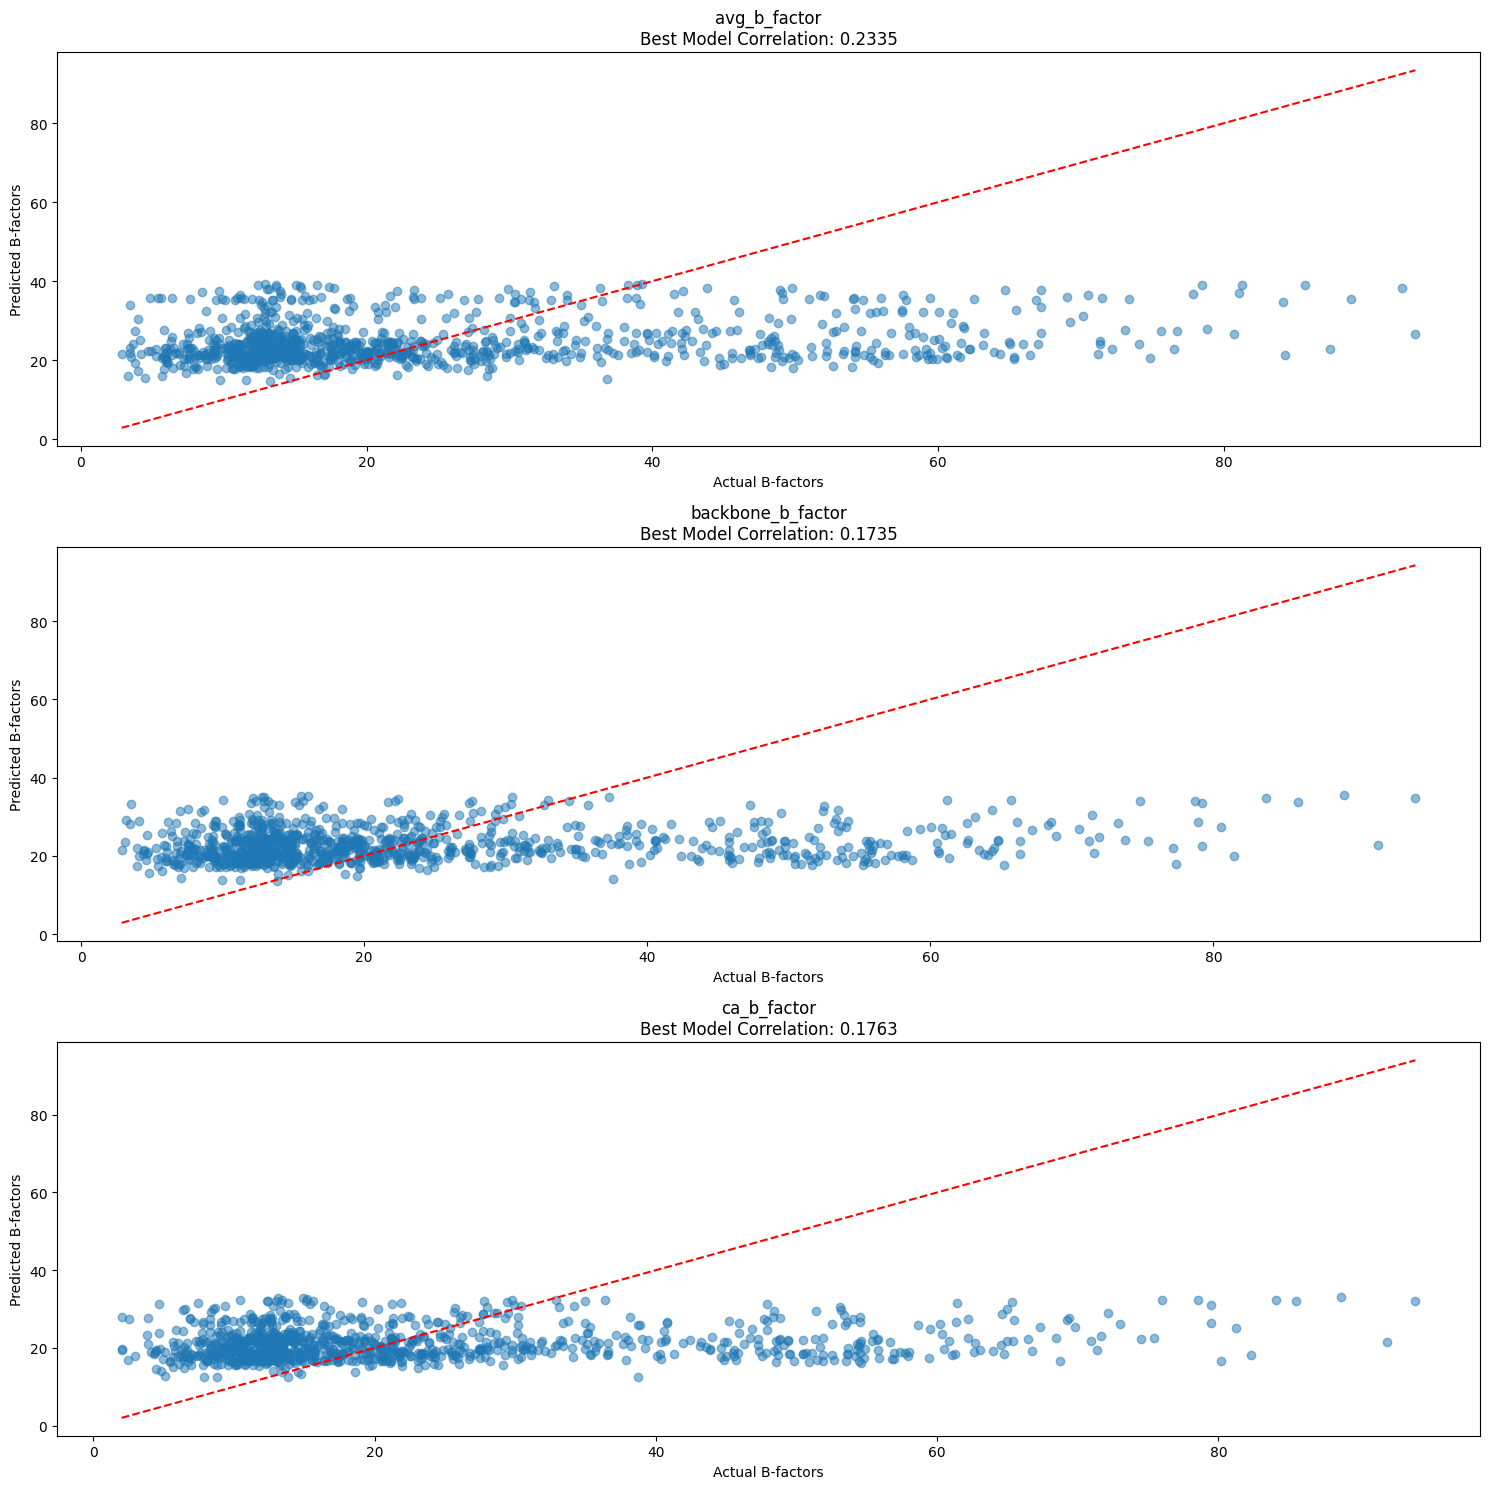


Best LSTM Model Configurations:

avg_b_factor:
Layers: [128, 64]
Batch Size: 64
Learning Rate: 0.0005
Correlation: 0.2335

backbone_b_factor:
Layers: [128, 64]
Batch Size: 64
Learning Rate: 0.001
Correlation: 0.1735

ca_b_factor:
Layers: [128, 64]
Batch Size: 32
Learning Rate: 0.0005
Correlation: 0.1763


In [30]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from itertools import product

# Define B-factor types to analyze
b_factor_types = ["avg_b_factor", "backbone_b_factor", "ca_b_factor"]

# Dictionary to store results for each B-factor type
all_type_results = {}

for b_factor_type in b_factor_types:
    print(f"\n{'='*40}")
    print(f"Training LSTM models for {b_factor_type}")
    print(f"{'='*40}")

    # Prepare combined dataset with the new function
    X, y = prepare_combined_dataset(df, b_factor_type)

    # Reshape X for LSTM input: [samples, time steps, features]
    X = X.reshape((X.shape[0], 1, X.shape[1]))

    # Scale B-factors
    scaler = MinMaxScaler()
    y = scaler.fit_transform(y.reshape(-1, 1)).flatten()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define hyperparameter combinations
    layer_configurations = [
        [128, 64],
        [256, 128, 64, 1]  # Deeper configuration
 # Deeper configuration
    ]
    batch_sizes = [32, 64]
    learning_rates = [0.001, 0.0005]

    # Store results
    results = []

    # Try all combinations
    for layers, batch_size, lr in product(layer_configurations, batch_sizes, learning_rates):
        # Create model name
        model_name = f"Layers: {layers}, Batch: {batch_size}, LR: {lr}"
        print(f"\nTraining model: {model_name}")

        # Build LSTM model
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])))

        # Add LSTM layers according to configuration
        for units in layers[:-1]:  # All LSTM layers except the last
            model.add(tf.keras.layers.LSTM(units, return_sequences=True, activation='relu'))

        # Last LSTM layer without return_sequences
        model.add(tf.keras.layers.LSTM(layers[-1], activation='relu', return_sequences=False))

        # Output layer
        model.add(tf.keras.layers.Dense(1))

        # Compile model
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        # Train model
        history = model.fit(
            X_train, y_train,
            epochs=20,
            batch_size=batch_size,
            validation_split=0.2,
            verbose=0
        )

        # Evaluate model
        y_pred = model.predict(X_test, verbose=0)

        # Inverse transform predictions and actual values back to original scale
        y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

        correlation, p_value = pearsonr(y_test_original, y_pred_original)

        # Store results
        results.append({
            'model_name': model_name,
            'correlation': correlation,
            'p_value': p_value,
            'history': history.history,
            'predictions': y_pred_original,  # Store original scale predictions
            'actuals': y_test_original,      # Store original scale actuals
            'layers': layers,
            'batch_size': batch_size,
            'learning_rate': lr
        })

        print(f"Pearson Correlation: {correlation:.4f}")

    # Sort results by correlation
    results.sort(key=lambda x: x['correlation'], reverse=True)
    all_type_results[b_factor_type] = results

    # Print summary for this B-factor type
    print(f"\nModel Performance Summary for {b_factor_type} (sorted by correlation):")
    print("-" * 80)
    for i, result in enumerate(results, 1):
        print(f"{i}. {result['model_name']}")
        print(f"   Correlation: {result['correlation']:.4f}")
        print(f"   P-value: {result['p_value']:.4e}")
        print("-" * 80)

# Visualization for all B-factor types
plt.figure(figsize=(15, 5 * len(b_factor_types)))

for idx, b_factor_type in enumerate(b_factor_types):
    results = all_type_results[b_factor_type]
    best_result = results[0]

    # Plot predictions vs actuals for best model
    plt.subplot(len(b_factor_types), 1, idx + 1)
    plt.scatter(best_result['actuals'], best_result['predictions'], alpha=0.5)
    plt.plot([min(best_result['actuals']), max(best_result['actuals'])],
             [min(best_result['actuals']), max(best_result['actuals'])], 'r--')
    plt.xlabel('Actual B-factors')
    plt.ylabel('Predicted B-factors')
    plt.title(f'{b_factor_type}\nBest Model Correlation: {best_result["correlation"]:.4f}')

plt.tight_layout()
plt.show()

# Print best configurations for each type
print("\nBest LSTM Model Configurations:")
for b_factor_type in b_factor_types:
    best_result = all_type_results[b_factor_type][0]
    print(f"\n{b_factor_type}:")
    print(f"Layers: {best_result['layers']}")
    print(f"Batch Size: {best_result['batch_size']}")
    print(f"Learning Rate: {best_result['learning_rate']}")
    print(f"Correlation: {best_result['correlation']:.4f}")


Preparing dataset for avg_b_factor

Preparing dataset for avg_b_factor
Number of proteins: 13

Processing 2BXO:
Sequence length: 582
Feature shape: (582, 21)
Target shape: (582,)

Processing 1A3N:
Sequence length: 141
Feature shape: (141, 21)
Target shape: (141,)

Processing 1GFL:
Sequence length: 230
Feature shape: (230, 21)
Target shape: (230,)

Processing 2LYZ:
Sequence length: 129
Feature shape: (129, 21)
Target shape: (129,)

Processing 1RCX:
Sequence length: 467
Feature shape: (467, 21)
Target shape: (467,)

Processing 1QQW:
Sequence length: 499
Feature shape: (499, 21)
Target shape: (499,)

Processing 1EFC:
Sequence length: 386
Feature shape: (386, 21)
Target shape: (386,)

Processing 1DP0:
Sequence length: 1011
Feature shape: (1011, 21)
Target shape: (1011,)

Processing 1A8E:
Sequence length: 329
Feature shape: (329, 21)
Target shape: (329,)

Processing 2GLS:
Sequence length: 468
Feature shape: (468, 21)
Target shape: (468,)

Processing 1AKE:
Sequence length: 214
Feature shape:

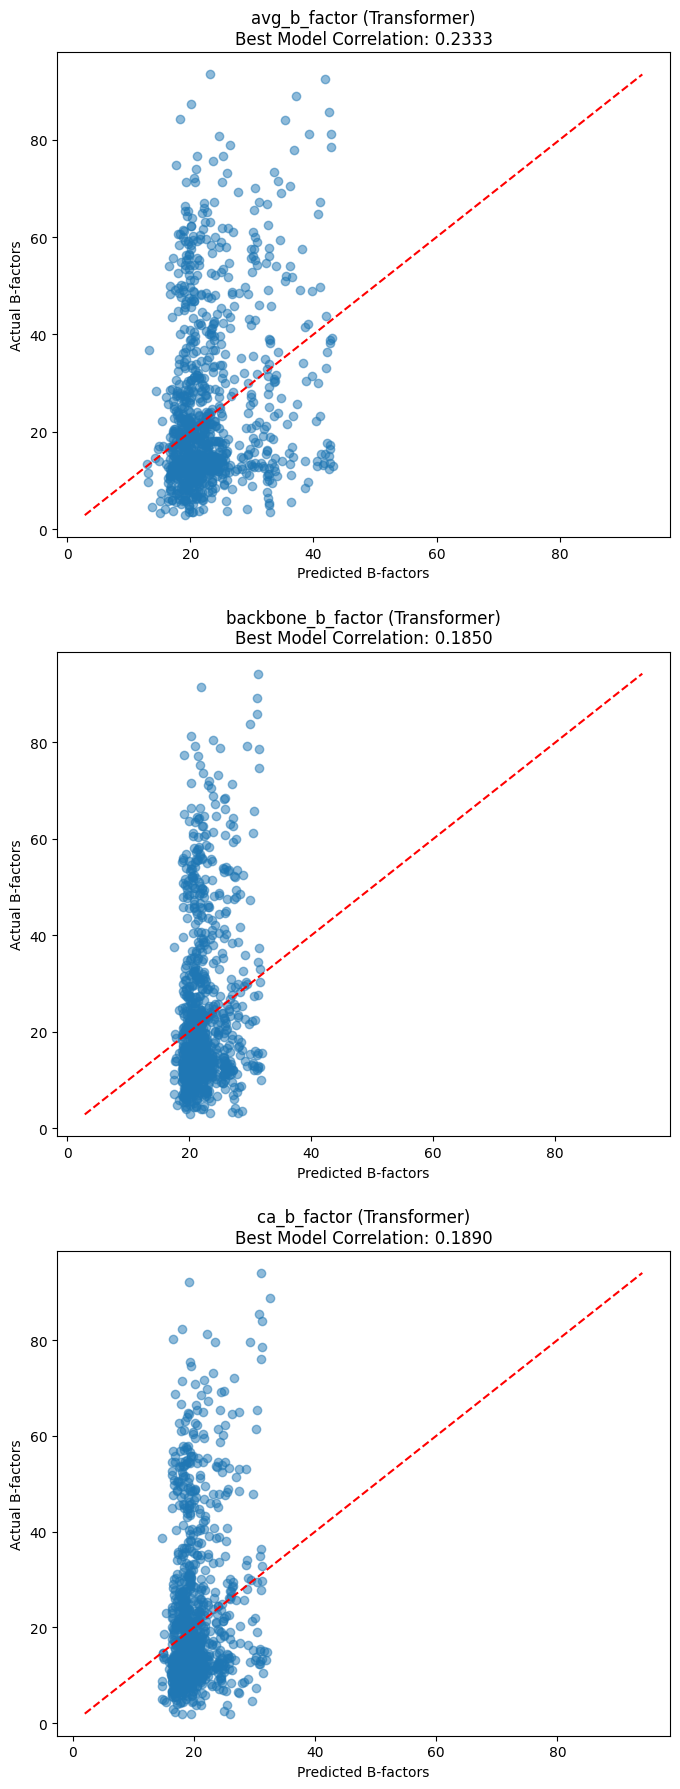


Best Transformer Model Configurations:

avg_b_factor:
Feed-forward dimension: 256
Number of transformer blocks: 4
Batch Size: 32
Learning Rate: 0.0001
Correlation: 0.2333

backbone_b_factor:
Feed-forward dimension: 256
Number of transformer blocks: 4
Batch Size: 16
Learning Rate: 0.0001
Correlation: 0.1850

ca_b_factor:
Feed-forward dimension: 512
Number of transformer blocks: 6
Batch Size: 32
Learning Rate: 0.0003
Correlation: 0.1890


In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
from itertools import product

# Define Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, ff_dim=256, num_blocks=4, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, ff_dim)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(ff_dim, dropout) for _ in range(num_blocks)
        ])
        self.layer_norm = nn.LayerNorm(ff_dim)
        self.fc1 = nn.Linear(ff_dim, 64)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, 1)
        self.gelu = nn.GELU()

    def forward(self, x):
        batch_size = x.size(0)
        x = self.input_proj(x)
        for block in self.transformer_blocks:
            x = block(x)
        x = self.layer_norm(x)
        x = self.gelu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x.view(batch_size)

class TransformerBlock(nn.Module):
    def __init__(self, ff_dim, dropout=0.1):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(ff_dim)
        self.fc1 = nn.Linear(ff_dim, ff_dim * 4)
        self.fc2 = nn.Linear(ff_dim * 4, ff_dim)
        self.layer_norm2 = nn.LayerNorm(ff_dim)
        self.fc3 = nn.Linear(ff_dim, ff_dim)
        self.dropout = nn.Dropout(dropout)
        self.gelu = nn.GELU()

    def forward(self, x):
        residual = x
        x = self.layer_norm1(x)
        x = self.gelu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = x + residual

        residual = x
        x = self.layer_norm2(x)
        x = self.gelu(self.fc3(x))
        x = self.dropout(x)
        x = x + residual
        return x

# Define B-factor types to analyze and prepare dataset
b_factor_types = ["avg_b_factor", "backbone_b_factor", "ca_b_factor"]
prepared_datasets = {}

# Prepare and store datasets once
for b_factor_type in b_factor_types:
    print(f"Preparing dataset for {b_factor_type}")
    X, y = prepare_combined_dataset(df, b_factor_type)
    scaler = MinMaxScaler()
    y = scaler.fit_transform(y.reshape(-1, 1)).flatten()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    prepared_datasets[b_factor_type] = {
        'X_train': torch.FloatTensor(X_train),
        'X_test': torch.FloatTensor(X_test),
        'y_train': torch.FloatTensor(y_train),
        'y_test': torch.FloatTensor(y_test),
        'scaler': scaler  # Store scaler for inverse transformation
    }

# Training and evaluation
all_type_results = {}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for b_factor_type in b_factor_types:
    print(f"\n{'='*40}")
    print(f"Training Transformer models for {b_factor_type}")
    print(f"{'='*40}")

    data = prepared_datasets[b_factor_type]
    X_train, X_test = data['X_train'], data['X_test']
    y_train, y_test = data['y_train'], data['y_test']
    scaler = data['scaler']

    # Define hyperparameter combinations
    transformer_configs = [{'ff_dim': 256, 'blocks': 4}, {'ff_dim': 512, 'blocks': 6}]
    batch_sizes = [16, 32]
    learning_rates = [3e-4, 1e-4]
    results = []

    for config, batch_size, lr in product(transformer_configs, batch_sizes, learning_rates):
        model_name = f"FF_dim: {config['ff_dim']}, Blocks: {config['blocks']}, Batch: {batch_size}, LR: {lr}"
        print(f"\nTraining model: {model_name}")

        # Initialize model
        model = TransformerModel(
            input_dim=X_train.shape[1],
            ff_dim=config['ff_dim'],
            num_blocks=config['blocks']
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        # DataLoaders
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

        train_losses, val_losses = [], []
        for epoch in range(20):
            model.train()
            epoch_loss = 0
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            train_losses.append(epoch_loss / len(train_loader))

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_X, batch_y in test_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    val_outputs = model(batch_X)
                    val_loss += criterion(val_outputs, batch_y).item()
            val_losses.append(val_loss / len(test_loader))

        # Evaluation
        model.eval()
        y_pred, y_test_list = [], []
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X = batch_X.to(device)
                predictions = model(batch_X).cpu().numpy()
                y_pred.extend(predictions)
                y_test_list.extend(batch_y.numpy())

        # Scale back predictions
        y_pred_original = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).flatten()
        y_test_original = scaler.inverse_transform(np.array(y_test_list).reshape(-1, 1)).flatten()
        correlation, _ = pearsonr(y_test_original, y_pred_original)

        results.append({
            'model_name': model_name,
            'correlation': correlation,
            'history': {'loss': train_losses, 'val_loss': val_losses},
            'predictions': y_pred_original,
            'actuals': y_test_original,
            'config': config,
            'batch_size': batch_size,
            'learning_rate': lr
        })

        print(f"Pearson Correlation: {correlation:.4f}")

    # Sort results by correlation
    results.sort(key=lambda x: x['correlation'], reverse=True)
    all_type_results[b_factor_type] = results

    # Visualization
plt.figure(figsize=(20, 6 * len(b_factor_types)))  # Increased figure size

for idx, b_factor_type in enumerate(b_factor_types):
    results = all_type_results[b_factor_type]
    best_result = results[0]

    # Predictions vs actuals
    plt.subplot(len(b_factor_types), 3, idx*3 + 1)
    plt.scatter(best_result['predictions'], best_result['actuals'], alpha=0.5)
    plt.plot([min(best_result['actuals']), max(best_result['actuals'])],
             [min(best_result['actuals']), max(best_result['actuals'])], 'r--')
    plt.xlabel('Predicted B-factors')
    plt.ylabel('Actual B-factors')
    plt.title(f'{b_factor_type} (Transformer)\nBest Model Correlation: {best_result["correlation"]:.4f}')


plt.tight_layout(h_pad=2, w_pad=3)  # Added padding between subplots
plt.show()

# Print best configurations
print("\nBest Transformer Model Configurations:")
for b_factor_type in b_factor_types:
    best_result = all_type_results[b_factor_type][0]
    print(f"\n{b_factor_type}:")
    print(f"Feed-forward dimension: {best_result['config']['ff_dim']}")
    print(f"Number of transformer blocks: {best_result['config']['blocks']}")
    print(f"Batch Size: {best_result['batch_size']}")
    print(f"Learning Rate: {best_result['learning_rate']}")
    print(f"Correlation: {best_result['correlation']:.4f}")

In [32]:
from transformers import BertModel, BertTokenizer
import torch
import numpy as np

# Load ProBERT model and tokenizer
model = BertModel.from_pretrained("Rostlab/prot_bert", output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert")

# Function to generate embeddings for a sequence
def generate_probert_embeddings(sequence):
    # ProBERT expects spaces between each amino acid
    sequence = " ".join(sequence)
    tokens = tokenizer(sequence, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**tokens)

    # Extract hidden states from the last layer
    hidden_states = outputs.hidden_states[-1]
    residue_embeddings = hidden_states.squeeze(0)  # Shape: (seq_length + 2, embedding_dim)

    # Remove special tokens (first and last tokens: [CLS] and [SEP])
    residue_embeddings = residue_embeddings[1:-1]  # Shape: (seq_length, embedding_dim)
    return residue_embeddings.cpu().numpy()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [1]:
# Function to evaluate models and return performance metrics
def evaluate_models(X, y, model_name, model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    pearson, _ = pearsonr(y_test, y_pred)
    return {'mse': mse, 'r2': r2, 'pearson': pearson, 'y_test': y_test, 'y_pred': y_pred, 'model_name': model_name}

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0)
}

# Define B-factor types to analyze
b_factor_types = ["avg_b_factor", "backbone_b_factor", "ca_b_factor"]
results = {}

# Train and evaluate models for each B-factor type
for b_type in b_factor_types:
    results[b_type] = []

    for idx, row in df.iterrows():
        pdb_id = row['pdb_id']
        embeddings = protein_embeddings[pdb_id]  # Get stored embeddings for this pdb_id
        b_factors = np.array(row[b_type])  # Retrieve B-factors

        if embeddings.shape[0] != len(b_factors):
            print(f"Skipping {pdb_id} due to mismatched embedding and B-factor lengths.")
            continue

        # For each model, evaluate and store the best result
        for model_name, model in models.items():
            model_results = evaluate_models(embeddings, b_factors, model_name, model)
            results[b_type].append(model_results)

    # Keep the best model based on R² score
    results[b_type].sort(key=lambda x: x['r2'], reverse=True)
    results[b_type] = results[b_type][0]

# Plot results
fig, axes = plt.subplots(len(b_factor_types), 1, figsize=(8, 15))
fig.suptitle('Best Model Performance for Different B-factor Types')

for i, b_type in enumerate(b_factor_types):
    res = results[b_type]
    axes[i].scatter(res['y_test'], res['y_pred'], alpha=0.5)
    axes[i].plot([min(res['y_test']), max(res['y_test'])], [min(res['y_test']), max(res['y_test'])], 'r--')
    axes[i].set_title(f'{b_type}\nBest Model: {res["model_name"]}\nPearson: {res["pearson"]:.3f}\nR²: {res["r2"]:.3f}')
    axes[i].set_xlabel('Actual B-factors')
    axes[i].set_ylabel('Predicted B-factors')

plt.tight_layout()
plt.show()

# Print detailed results
for b_type in b_factor_types:
    res = results[b_type]
    print(f"\nResults for {b_type}:")
    print(f"Best Model: {res['model_name']}")
    print(f"MSE: {res['mse']:.3f}")
    print(f"R²: {res['r2']:.3f}")
    print(f"Pearson: {res['pearson']:.3f}")

NameError: name 'LinearRegression' is not defined

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

def pad_sequences(sequences, max_len, padding_value=0):
    # Adjust shape based on sequence dimensions
    padded_sequences = np.full((len(sequences), max_len, sequences[0].shape[1]), padding_value)
    for i, seq in enumerate(sequences):
        padded_sequences[i, :len(seq)] = seq
    return padded_sequences

# Function to prepare dataset with padding for RNN input
def prepare_sequential_dataset(df, b_factor_type, embeddings_dict):
    all_features = []
    all_targets = []
    max_seq_len = 0  # Track maximum sequence length for padding

    for idx, row in df.iterrows():
        pdb_id = row['pdb_id']
        if pdb_id in embeddings_dict:
            embeddings = embeddings_dict[pdb_id]
            b_factors = np.array(row[b_factor_type])

            # Check if embeddings and B-factors align in length
            if embeddings.shape[0] == len(b_factors):
                all_features.append(embeddings)
                all_targets.append(b_factors)
                max_seq_len = max(max_seq_len, len(b_factors))  # Update max sequence length
            else:
                print(f"Skipping {pdb_id} due to length mismatch.")

    # Pad sequences to ensure fixed length
    X_padded = pad_sequences(all_features, max_len=max_seq_len, padding_value=0)
    y_padded = pad_sequences([np.expand_dims(y, -1) for y in all_targets], max_len=max_seq_len, padding_value=0)
    y_padded = y_padded.squeeze(-1)  # Ensure shape is [batch_size, max_seq_len]

    return X_padded, y_padded

# Prepare the padded dataset
X, y = prepare_sequential_dataset(df, 'avg_b_factor', protein_embeddings)

# Scale B-factors
scaler = MinMaxScaler()
y = scaler.fit_transform(y.reshape(-1, 1)).reshape(y.shape)

# Convert to PyTorch tensors and create DataLoader
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

# Check the shapes of X and y after padding to ensure compatibility
print("Padded X shape:", X.shape)
print("Padded y shape:", y.shape)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from itertools import product

class SimpleRNN(nn.Module):
    def __init__(self, input_size=1024, hidden_size=128, num_layers=2, dropout=0.2):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        predictions = self.fc(rnn_out)
        return predictions.squeeze(-1)

class ProteinDataset(Dataset):
    def __init__(self, embeddings, b_factors):
        self.embeddings = torch.FloatTensor(embeddings)
        self.b_factors = torch.FloatTensor(b_factors)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.b_factors[idx]

def train_rnn_model(embeddings, b_factors, hidden_size, num_layers, dropout, lr, n_epochs=3):
    # Convert to numpy arrays
    embeddings = np.array(embeddings)
    b_factors = np.array(b_factors)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, b_factors, test_size=0.2, random_state=42
    )

    # Scale B-factors
    scaler = StandardScaler()
    y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).squeeze()
    y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).squeeze()

    # Create datasets and dataloaders
    train_dataset = ProteinDataset(X_train, y_train_scaled)
    test_dataset = ProteinDataset(X_test, y_test_scaled)

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1)

    # Initialize model with specific hyperparameters
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SimpleRNN(hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0

        for batch_embeddings, batch_b_factors in train_loader:
            batch_embeddings = batch_embeddings.to(device)
            batch_b_factors = batch_b_factors.to(device)

            optimizer.zero_grad()
            predictions = model(batch_embeddings)
            loss = criterion(predictions, batch_b_factors)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

    # Evaluation
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_embeddings, batch_b_factors in test_loader:
            batch_embeddings = batch_embeddings.to(device)
            predictions = model(batch_embeddings)

            # Adjust predictions and targets to 1-dimensional arrays
            predictions_np = scaler.inverse_transform(
                predictions.cpu().numpy().reshape(-1, 1)
            ).squeeze()
            targets_np = scaler.inverse_transform(
                batch_b_factors.numpy().reshape(-1, 1)
            ).squeeze()

            # Ensure predictions_np and targets_np are 1-dimensional
            predictions_np = np.atleast_1d(predictions_np)
            targets_np = np.atleast_1d(targets_np)

            # Append to lists
            all_predictions.extend(predictions_np)
            all_targets.extend(targets_np)

    # Calculate metrics
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    pearson_corr, _ = pearsonr(all_targets, all_predictions)
    mse = mean_squared_error(all_targets, all_predictions)

    return model, pearson_corr, mse, all_predictions, all_targets

# Define hyperparameter combinations
hidden_sizes = [64]
num_layers_options = [2, 4]
dropout_rates = [0.1, 0.5]  # Two dropout rates
learning_rates = [0.001, 0.01]  # Two learning rates

# Create combinations and limit to first 2
hyperparameter_combinations = list(product(
    hidden_sizes,
    num_layers_options,
    dropout_rates,
    learning_rates
))[:2]

# Train models for each B-factor type
b_factor_types = ["avg_b_factor", "backbone_b_factor", "ca_b_factor"]
best_results = {}

for b_type in b_factor_types:
    print(f"\n{'='*50}")
    print(f"Training models for {b_type}")
    print(f"{'='*50}")
    models_results = []

    # Combine all protein embeddings and b-factors
    all_embeddings = []
    all_b_factors = []

    # Collect data from all proteins
    for idx, row in df.iterrows():
        pdb_id = row['pdb_id']
        b_factors = row[b_type]
        embeddings = protein_embeddings.get(pdb_id, None)

        # Check for mismatched length or missing embeddings
        if embeddings is None:
            print(f"Skipping {pdb_id} due to missing embeddings.")
            continue
        elif len(embeddings) != len(b_factors):
            print(f"Skipping {pdb_id} due to mismatched lengths: embeddings ({len(embeddings)}) vs b_factors ({len(b_factors)})")
            continue

        all_embeddings.extend(embeddings)
        all_b_factors.extend(b_factors)

    # Convert to numpy arrays
    all_embeddings = np.array(all_embeddings)
    all_b_factors = np.array(all_b_factors)

    # Train models with different hyperparameters on the combined dataset
    for hidden_size, num_layers, dropout, lr in hyperparameter_combinations:
        print(f"\nTraining model with:")
        print(f"Hidden Size: {hidden_size}, Layers: {num_layers}, Dropout: {dropout}, LR: {lr}")

        model, pearson, mse, preds, targets = train_rnn_model(
            all_embeddings, all_b_factors, hidden_size, num_layers, dropout, lr
        )

        models_results.append({
            'model': model,
            'pearson_corr': pearson,
            'mse': mse,
            'predictions': preds,
            'targets': targets,
            'hyperparameters': {
                'hidden_size': hidden_size,
                'num_layers': num_layers,
                'dropout': dropout,
                'lr': lr
            }
        })

        print(f"Pearson: {pearson:.3f}, MSE: {mse:.3f}")

    # Find best model for this B-factor type
    if models_results:
        best_model = max(models_results, key=lambda x: x['pearson_corr'])
        best_results[b_type] = best_model
    else:
        print(f"No valid models trained for {b_type} due to data issues.")

# Plot best models
plt.figure(figsize=(15, 5))
for i, b_type in enumerate(b_factor_types, 1):
    if b_type in best_results:
        best = best_results[b_type]
        plt.subplot(1, len(b_factor_types), i)
        plt.scatter(best['targets'], best['predictions'], alpha=0.5)
        plt.plot([min(best['targets']), max(best['targets'])],
                 [min(best['targets']), max(best['targets'])], 'r--')

        params = best['hyperparameters']
        plt.title(f"{b_type}\nPearson: {best['pearson_corr']:.3f}\nMSE: {best['mse']:.3f}\n" +
                  f"HS={params['hidden_size']}, L={params['num_layers']}, D={params['dropout']}")
        plt.xlabel('Actual B-factors')
        plt.ylabel('Predicted B-factors')

plt.tight_layout()
plt.show()

# Print final summary of best models
print("\nBest Models Summary:")
for b_type in b_factor_types:
    if b_type in best_results:
        best = best_results[b_type]
        params = best['hyperparameters']
        print(f"\n{b_type}:")
        print(f"  Pearson: {best['pearson_corr']:.3f}")
        print(f"  MSE: {best['mse']:.3f}")
        print(f"  Hidden Size: {params['hidden_size']}")
        print(f"  Layers: {params['num_layers']}")
        print(f"  Dropout: {params['dropout']}")
        print(f"  Learning Rate: {params['lr']}")


In [ ]:
# Load ProBERT model and tokenizer
from transformers import BertModel, BertTokenizer
import torch
import numpy as np

model = BertModel.from_pretrained("Rostlab/prot_bert", output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert")

# Function to generate embeddings for a sequence
def generate_probert_embeddings(sequence):
    sequence = " ".join(sequence)
    tokens = tokenizer(sequence, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**tokens)

    hidden_states = outputs.hidden_states[-1]
    residue_embeddings = hidden_states.squeeze(0)[1:-1]  # Shape: (seq_length, embedding_dim)
    return residue_embeddings.cpu().numpy()

# Padding function for sequences
def pad_sequences(sequences, max_len, padding_value=0):
    padded_sequences = np.full((len(sequences), max_len, sequences[0].shape[1]), padding_value)
    for i, seq in enumerate(sequences):
        padded_sequences[i, :len(seq)] = seq
    return padded_sequences

# Prepare the dataset with padding
def prepare_sequential_dataset(df, b_factor_type, embeddings_dict):
    all_features = []
    all_targets = []
    max_seq_len = 0

    for idx, row in df.iterrows():
        pdb_id = row['pdb_id']
        if pdb_id in embeddings_dict:
            embeddings = embeddings_dict[pdb_id]
            b_factors = np.array(row[b_factor_type])

            if embeddings.shape[0] == len(b_factors):
                all_features.append(embeddings)
                all_targets.append(b_factors)
                max_seq_len = max(max_seq_len, len(b_factors))
            else:
                print(f"Skipping {pdb_id} due to length mismatch.")

    X_padded = pad_sequences(all_features, max_len=max_seq_len, padding_value=0)
    y_padded = pad_sequences([np.expand_dims(y, -1) for y in all_targets], max_len=max_seq_len, padding_value=0)
    y_padded = y_padded.squeeze(-1)  # Ensure shape is [batch_size, max_seq_len]

    return X_padded, y_padded

# Prepare padded dataset
X_padded, y_padded = prepare_sequential_dataset(df, 'avg_b_factor', protein_embeddings)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from itertools import product

class LSTMModel(nn.Module):
    def __init__(self, input_size=1024, hidden_size=128, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.fc(lstm_out)
        return predictions.squeeze(-1)

class ProteinDataset(Dataset):
    def __init__(self, embeddings, b_factors, max_length=None):
        # Convert lists to tensors if they aren't already
        if isinstance(embeddings, list):
            # Pad sequences to max_length if specified
            if max_length is not None:
                padded_embeddings = []
                padded_b_factors = []
                for emb, b_fac in zip(embeddings, b_factors):
                    pad_length = max_length - len(emb)
                    if pad_length > 0:
                        padded_emb = np.pad(emb, ((0, pad_length), (0, 0)), mode='constant')
                        padded_b_fac = np.pad(b_fac, (0, pad_length), mode='constant')
                    else:
                        padded_emb = emb[:max_length]
                        padded_b_fac = b_fac[:max_length]
                    padded_embeddings.append(padded_emb)
                    padded_b_factors.append(padded_b_fac)
                embeddings = np.array(padded_embeddings)
                b_factors = np.array(padded_b_factors)

            self.embeddings = torch.FloatTensor(embeddings)
            self.b_factors = torch.FloatTensor(b_factors)
        else:
            self.embeddings = embeddings
            self.b_factors = b_factors

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.b_factors[idx]

def prepare_data_for_lstm(df, protein_embeddings, b_factor_type):
    all_embeddings = []
    all_b_factors = []

    for idx, row in df.iterrows():
        pdb_id = row['pdb_id']
        if pdb_id in protein_embeddings:
            embeddings = protein_embeddings[pdb_id]
            b_factors = np.array(row[b_factor_type])

            if len(embeddings) == len(b_factors):
                all_embeddings.append(embeddings)
                all_b_factors.append(b_factors)
            else:
                print(f"Skipping {pdb_id} due to length mismatch")

    return all_embeddings, all_b_factors

def train_lstm_model(df, protein_embeddings, b_factor_type, hidden_size, num_layers, dropout, lr, n_epochs=50):
    # Prepare data
    all_embeddings, all_b_factors = prepare_data_for_lstm(df, protein_embeddings, b_factor_type)

    # Find maximum sequence length for padding
    max_length = max(len(emb) for emb in all_embeddings)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        all_embeddings, all_b_factors, test_size=0.2, random_state=42
    )

    # Scale B-factors
    scaler = StandardScaler()
    y_train_flat = np.concatenate(y_train)
    y_train_scaled = scaler.fit_transform(y_train_flat.reshape(-1, 1)).squeeze()

    # Reshape y_train_scaled back to original structure
    start_idx = 0
    y_train_scaled_list = []
    for y in y_train:
        end_idx = start_idx + len(y)
        y_train_scaled_list.append(y_train_scaled[start_idx:end_idx])
        start_idx = end_idx

    # Create datasets with padding
    train_dataset = ProteinDataset(X_train, y_train_scaled_list, max_length)
    test_dataset = ProteinDataset(X_test, y_test, max_length)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1)

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LSTMModel(
        input_size=1024,  # ProBERT embedding dimension
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0

        for batch_embeddings, batch_b_factors in train_loader:
            batch_embeddings = batch_embeddings.to(device)
            batch_b_factors = batch_b_factors.to(device)

            optimizer.zero_grad()
            predictions = model(batch_embeddings)
            loss = criterion(predictions, batch_b_factors)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

    # Evaluation
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_embeddings, batch_b_factors in test_loader:
            batch_embeddings = batch_embeddings.to(device)
            predictions = model(batch_embeddings)

            # Scale back predictions
            predictions_np = scaler.inverse_transform(
                predictions.cpu().numpy().reshape(-1, 1)
            ).squeeze()
            targets_np = batch_b_factors.numpy().squeeze()

            all_predictions.extend(predictions_np)
            all_targets.extend(targets_np)

    # Calculate metrics
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    pearson_corr, _ = pearsonr(all_targets, all_predictions)
    mse = mean_squared_error(all_targets, all_predictions)

    return model, pearson_corr, mse, all_predictions, all_targets

# Model configurations and training loop
def train_and_evaluate_lstm_models(df, protein_embeddings):
    model_configs = [
        {'hidden_size': 64, 'num_layers': 1, 'dropout': 0, 'lr': 0.001},        # Baseline config
        {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.001},      # More layers, slight dropout
        {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.2, 'lr': 0.0001},     # Same layers, higher dropout, lower learning rate
        {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.001},     # Larger hidden size
        {'hidden_size': 128, 'num_layers': 3, 'dropout': 0.15, 'lr': 0.001},    # Larger hidden size, more layers, moderate dropout
        {'hidden_size': 64, 'num_layers': 3, 'dropout': 0.2, 'lr': 0.0005},
    ]

    b_factor_types = ["avg_b_factor", "backbone_b_factor", "ca_b_factor"]
    best_results = {}

    for b_type in b_factor_types:
        print(f"\n{'='*50}")
        print(f"Training models for {b_type}")
        print(f"{'='*50}")

        models_results = []

        for config in model_configs:
            print(f"\nTraining model with:")
            print(f"Hidden Size: {config['hidden_size']}, Layers: {config['num_layers']}, "
                  f"Dropout: {config['dropout']}, LR: {config['lr']}")

            model, pearson, mse, preds, targets = train_lstm_model(
                df,
                protein_embeddings,
                b_type,
                config['hidden_size'],
                config['num_layers'],
                config['dropout'],
                config['lr']
            )

            models_results.append({
                'model': model,
                'pearson_corr': pearson,
                'mse': mse,
                'predictions': preds,
                'targets': targets,
                'config': config
            })

            print(f"Pearson: {pearson:.3f}, MSE: {mse:.3f}")

        # Find best model for this B-factor type
        best_model = max(models_results, key=lambda x: x['pearson_corr'])
        best_results[b_type] = best_model

    return best_results

# Plotting and results display
def plot_results(best_results):
    plt.figure(figsize=(15, 5))

    for i, (b_type, best) in enumerate(best_results.items(), 1):
        plt.subplot(1, 3, i)
        plt.scatter(best['targets'], best['predictions'], alpha=0.5)
        plt.plot([min(best['targets']), max(best['targets'])],
                 [min(best['targets']), max(best['targets'])], 'r--')

        config = best['config']
        plt.title(f"{b_type}\nPearson: {best['pearson_corr']:.3f}\nMSE: {best['mse']:.3f}\n" +
                  f"HS={config['hidden_size']}, L={config['num_layers']}, D={config['dropout']}")
        plt.xlabel('Actual B-factors')
        plt.ylabel('Predicted B-factors')

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\nBest Models Summary:")
    for b_type, best in best_results.items():
        config = best['config']
        print(f"\n{b_type}:")
        print(f"  Pearson: {best['pearson_corr']:.3f}")
        print(f"  MSE: {best['mse']:.3f}")
        print(f"  Hidden Size: {config['hidden_size']}")
        print(f"  Layers: {config['num_layers']}")
        print(f"  Dropout: {config['dropout']}")
        print(f"  Learning Rate: {config['lr']}")

In [ ]:
# First train all models and get results
best_results = train_and_evaluate_lstm_models(df, protein_embeddings)

# Then plot and display results
plot_results(best_results)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from itertools import product


class TransformerModel(nn.Module):
    def __init__(self, input_dim, ff_dim=256, num_blocks=4, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, ff_dim)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(ff_dim, dropout) for _ in range(num_blocks)
        ])
        self.layer_norm = nn.LayerNorm(ff_dim)
        self.fc1 = nn.Linear(ff_dim, 64)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, 1)
        self.gelu = nn.GELU()

    def forward(self, x):
        x = self.input_proj(x)
        for block in self.transformer_blocks:
            x = block(x)
        x = self.layer_norm(x)
        x = self.gelu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x.squeeze(-1)


class TransformerBlock(nn.Module):
    def __init__(self, ff_dim, dropout=0.1):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(ff_dim)
        self.fc1 = nn.Linear(ff_dim, ff_dim * 4)
        self.fc2 = nn.Linear(ff_dim * 4, ff_dim)
        self.layer_norm2 = nn.LayerNorm(ff_dim)
        self.fc3 = nn.Linear(ff_dim, ff_dim)
        self.dropout = nn.Dropout(dropout)
        self.gelu = nn.GELU()

    def forward(self, x):
        residual = x
        x = self.layer_norm1(x)
        x = self.gelu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = x + residual

        residual = x
        x = self.layer_norm2(x)
        x = self.gelu(self.fc3(x))
        x = self.dropout(x)
        x = x + residual
        return x


def prepare_transformer_dataset(df, protein_embeddings, b_factor_type):
    all_embeddings = []
    all_b_factors = []
    max_seq_len = 0

    for idx, row in df.iterrows():
        pdb_id = row['pdb_id']
        if pdb_id in protein_embeddings:
            embeddings = protein_embeddings[pdb_id]
            b_factors = np.array(row[b_factor_type])

            if embeddings.shape[0] == len(b_factors):
                all_embeddings.append(embeddings)
                all_b_factors.append(b_factors)
                max_seq_len = max(max_seq_len, len(b_factors))
            else:
                print(f"Skipping {pdb_id} due to length mismatch")

    # Pad sequences
    X_padded = np.zeros((len(all_embeddings), max_seq_len, all_embeddings[0].shape[1]))
    y_padded = np.zeros((len(all_b_factors), max_seq_len))

    for i, (emb, b_fac) in enumerate(zip(all_embeddings, all_b_factors)):
        X_padded[i, :len(emb)] = emb
        y_padded[i, :len(b_fac)] = b_fac

    return X_padded, y_padded


def train_transformer_models(df, protein_embeddings):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    b_factor_types = ["avg_b_factor", "backbone_b_factor", "ca_b_factor"]
    all_type_results = {}

    for b_factor_type in b_factor_types:
        print(f"\n{'='*40}")
        print(f"Training Transformer models for {b_factor_type}")
        print(f"{'='*40}")

        # Prepare dataset
        X, y = prepare_transformer_dataset(df, protein_embeddings, b_factor_type)

        # Scale B-factors
        scaler = MinMaxScaler()
        y = scaler.fit_transform(y.reshape(-1, 1)).reshape(y.shape)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Define hyperparameter combinations
        transformer_configs = [{'ff_dim': 256, 'blocks': 4}, {'ff_dim': 512, 'blocks': 6}]
        batch_sizes = [16, 32]
        learning_rates = [3e-4, 2e-4]
        results = []

        for config, batch_size, lr in product(transformer_configs, batch_sizes, learning_rates):
            model_name = f"FF_dim: {config['ff_dim']}, Blocks: {config['blocks']}, Batch: {batch_size}, LR: {lr}"
            print(f"\nTraining model: {model_name}")

            # Initialize model
            model = TransformerModel(
                input_dim=X_train.shape[2],  # ProBERT embedding dimension
                ff_dim=config['ff_dim'],
                num_blocks=config['blocks']
            ).to(device)

            # Convert to tensors and create dataloaders
            train_dataset = TensorDataset(
                torch.FloatTensor(X_train).to(device),
                torch.FloatTensor(y_train).to(device)
            )
            test_dataset = TensorDataset(
                torch.FloatTensor(X_test).to(device),
                torch.FloatTensor(y_test).to(device)
            )

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size)

            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            criterion = nn.MSELoss()

            # Training loop
            train_losses, val_losses = [], []
            for epoch in range(60):
                model.train()
                epoch_loss = 0
                for batch_X, batch_y in train_loader:
                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    optimizer.step()
                    epoch_loss += loss.item()

                train_losses.append(epoch_loss / len(train_loader))

                # Validation
                model.eval()
                val_loss = 0
                with torch.no_grad():
                    for batch_X, batch_y in test_loader:
                        val_outputs = model(batch_X)
                        val_loss += criterion(val_outputs, batch_y).item()
                val_losses.append(val_loss / len(test_loader))

            # Final evaluation
            model.eval()
            all_predictions = []
            all_targets = []

            with torch.no_grad():
                for batch_X, batch_y in test_loader:
                    predictions = model(batch_X).cpu().numpy()
                    all_predictions.extend(predictions.reshape(-1))
                    all_targets.extend(batch_y.cpu().numpy().reshape(-1))

            # Scale back predictions
            all_predictions = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1)).flatten()
            all_targets = scaler.inverse_transform(np.array(all_targets).reshape(-1, 1)).flatten()

            # Calculate correlation
            correlation, _ = pearsonr(all_targets, all_predictions)

            results.append({
                'model_name': model_name,
                'correlation': correlation,
                'history': {'loss': train_losses, 'val_loss': val_losses},
                'predictions': all_predictions,
                'actuals': all_targets,
                'config': config,
                'batch_size': batch_size,
                'learning_rate': lr
            })

            print(f"Pearson Correlation: {correlation:.4f}")

        results.sort(key=lambda x: x['correlation'], reverse=True)
        all_type_results[b_factor_type] = results

    return all_type_results


def plot_transformer_results(all_type_results):
    plt.figure(figsize=(20, 6 * len(all_type_results)))

    for idx, (b_type, results) in enumerate(all_type_results.items()):
        best_result = results[0]

        plt.subplot(len(all_type_results), 2, 2*idx + 1)
        plt.scatter(best_result['actuals'], best_result['predictions'], alpha=0.5)
        plt.plot([min(best_result['actuals']), max(best_result['actuals'])],
                 [min(best_result['actuals']), max(best_result['actuals'])], 'r--')
        plt.xlabel('Actual B-factors')
        plt.ylabel('Predicted B-factors')
        plt.title(f'{b_type} (Transformer)\nBest Model Correlation: {best_result["correlation"]:.4f}')

        # Plot training history
        plt.subplot(len(all_type_results), 2, 2*idx + 2)
        plt.plot(best_result['history']['loss'], label='Train Loss')
        plt.plot(best_result['history']['val_loss'], label='Val Loss')
        plt.title(f'{b_type} - Training History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\nBest Transformer Model Configurations:")
    for b_type, results in all_type_results.items():
        best_result = results[0]
        print(f"\n{b_type}:")
        print(f"Feed-forward dimension: {best_result['config']['ff_dim']}")
        print(f"Number of transformer blocks: {best_result['config']['blocks']}")
        print(f"Batch Size: {best_result['batch_size']}")
        print(f"Learning Rate: {best_result['learning_rate']}")
        print(f"Correlation: {best_result['correlation']:.4f}")

In [ ]:
# Train the models
results = train_transformer_models(df, protein_embeddings)

# Plot the results
plot_transformer_results(results)